# Multi-Type Anomaly Detection in SCADA Systems
## Beyond Attack Detection: Identifying Sensor and Process Anomalies

This notebook goes beyond simple attack detection to identify **multiple types of anomalies** that can occur in SCADA/ICS systems:

| Anomaly Type | Description | Potential Cause |
|--------------|-------------|----------------|
| **Sensor Drift** | Gradual deviation from expected values | Calibration issues, aging sensors |
| **Stuck Sensor** | Value remains constant when it shouldn't | Sensor failure, communication loss |
| **Noise Burst** | Sudden increase in signal noise | EMI, electrical interference |
| **Out-of-Range** | Values exceed physical limits | Sensor malfunction, attack |
| **Data Drop** | Missing or null values | Network issues, sensor failure |
| **Spike Anomaly** | Sudden sharp changes | Process upset, attack |
| **Correlation Break** | Related sensors no longer correlate | Attack, process change |

**Why This Matters for SCADA:**
- Not all anomalies are attacks - some are equipment failures
- Different anomaly types require different responses
- Early detection of sensor issues prevents false alarms and missed attacks

---

In [2]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Mounted at /content/drive
Google Drive mounted successfully!


## Step 1: Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("All imports successful!")

All imports successful!


## Step 2: Configuration

In [3]:
# =============================================================
# CONFIGURATION
# =============================================================

# Data path
DATA_PATH = '/content/drive/MyDrive/SWaT_2015/Physical/SWaT_Attack.csv'  # Or your data file

# Detection thresholds (can be tuned)
CONFIG = {
    # Stuck sensor detection
    'stuck_window': 60,           # Window size (seconds) to check for stuck values
    'stuck_threshold': 0.0001,    # Variance threshold below which sensor is "stuck"

    # Drift detection
    'drift_window': 300,          # Window for drift calculation (5 minutes)
    'drift_threshold': 3.0,       # Z-score threshold for drift

    # Noise detection
    'noise_window': 30,           # Window for noise calculation
    'noise_multiplier': 5.0,      # How many times normal noise = anomaly

    # Spike detection
    'spike_threshold': 5.0,       # Z-score for spike detection

    # Out-of-range (will be calculated per sensor)
    'oor_percentile': 99.9,       # Percentile for range limits

    # Correlation break
    'corr_window': 300,           # Window for correlation calculation
    'corr_threshold': 0.3,        # Minimum expected correlation
}

print("Configuration loaded!")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded!
  stuck_window: 60
  stuck_threshold: 0.0001
  drift_window: 300
  drift_threshold: 3.0
  noise_window: 30
  noise_multiplier: 5.0
  spike_threshold: 5.0
  oor_percentile: 99.9
  corr_window: 300
  corr_threshold: 0.3


## Step 3: Load Data

In [4]:
# Load data
print(f"Loading data from: {DATA_PATH}")

# Try different header configurations
try:
    data = pd.read_csv(DATA_PATH, header=1)
    if 'Unnamed' in str(data.columns[0]):
        data = pd.read_csv(DATA_PATH, header=0)
except:
    data = pd.read_csv(DATA_PATH)

# Clean column names
data.columns = data.columns.str.strip()

print(f"\n✅ Loaded {data.shape[0]:,} rows × {data.shape[1]} columns")

Loading data from: /content/drive/MyDrive/SWaT_2015/Physical/SWaT_Attack.csv

✅ Loaded 449,919 rows × 53 columns


In [5]:
# Identify sensor columns (numeric, excluding timestamp and labels)
exclude_cols = ['Timestamp', 'timestamp', 'Normal/Attack', 'label', 'Label']
sensor_cols = [col for col in data.columns if col not in exclude_cols]
sensor_cols = data[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Found {len(sensor_cols)} sensor columns:")
print(sensor_cols)

Found 51 sensor columns:
['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603']


In [6]:
# Get label column if exists
label_col = None
for col in ['Normal/Attack', 'label', 'Label']:
    if col in data.columns:
        label_col = col
        data[label_col] = data[label_col].replace({'A ttack': 'Attack'})
        break

if label_col:
    print(f"Label column: {label_col}")
    print(data[label_col].value_counts())

Label column: Normal/Attack
Normal/Attack
Normal    395298
Attack     54621
Name: count, dtype: int64


In [7]:
# Create sensor dataframe
sensors_df = data[sensor_cols].copy()

# Basic statistics
print("\nSensor Statistics:")
display(sensors_df.describe())


Sensor Statistics:


,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
count,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,...,449919.000000,449919.000000,449919.0,449919.000000,449919.000000,449919.000000,449919.000000,449919.0,449919.000000,449919.0
mean,1.714346,607.019967,1.665335,1.693251,1.006946,210.297302,8.528535,320.301478,1.702908,1.691584,...,0.283806,1.925862,1.0,232.173817,1.013408,174.714484,0.016566,1.0,1.009099,1.0
std,1.191716,125.303003,0.482323,0.461145,0.083051,35.157909,0.114844,16.631029,1.130277,0.470611,...,0.080924,0.261995,0.0,61.750930,0.412723,47.479809,0.159603,0.0,0.094956,0.0
min,0.000000,189.826300,0.000000,1.000000,1.000000,168.033800,6.000000,285.337100,0.000000,0.000000,...,0.000000,1.000000,1.0,9.468726,0.000000,3.140220,0.000000,1.0,1.000000,1.0
25%,0.000000,510.011100,1.000000,1.000000,1.000000,177.102000,8.441618,306.383000,0.000000,1.000000,...,0.306249,2.000000,1.0,248.029400,0.816967,186.698900,0.000000,1.0,1.000000,1.0
50%,2.477020,530.422500,2.000000,2.000000,1.000000,193.508100,8.551525,321.661100,2.446673,2.000000,...,0.306633,2.000000,1.0,249.295100,0.961138,187.724300,0.000000,1.0,1.000000,1.0
75%,2.577907,727.432100,2.000000,2.000000,1.000000,253.845200,8.610806,331.684200,2.454362,2.000000,...,0.308106,2.000000,1.0,250.881200,1.409669,189.118200,0.000128,1.0,1.000000,1.0
max,2.760145,925.032300,2.000000,2.000000,2.000000,267.719800,8.733210,384.465500,2.826899,2.000000,...,0.311693,2.000000,1.0,254.341800,1.970333,191.986000,1.802710,1.0,2.000000,1.0


---
## Anomaly Type 1: Stuck Sensor Detection

A **stuck sensor** shows constant or near-constant values when it should be varying. This can indicate:
- Sensor hardware failure
- Communication loss (last value held)
- Malicious value injection (replay attack)

In [8]:
def detect_stuck_sensors(df, window=60, threshold=0.0001):
    """
    Detect periods where sensor values are stuck (near-zero variance).

    Args:
        df: DataFrame with sensor columns
        window: Rolling window size
        threshold: Variance threshold below which sensor is "stuck"

    Returns:
        DataFrame with stuck flags for each sensor
    """
    stuck_flags = pd.DataFrame(index=df.index)

    for col in df.columns:
        # Calculate rolling variance
        rolling_var = df[col].rolling(window=window, min_periods=1).var()

        # Flag as stuck if variance below threshold
        stuck_flags[col] = (rolling_var < threshold).astype(int)

    return stuck_flags

print("Detecting stuck sensors...")
stuck_flags = detect_stuck_sensors(
    sensors_df,
    window=CONFIG['stuck_window'],
    threshold=CONFIG['stuck_threshold']
)

# Summary
stuck_summary = stuck_flags.sum()
stuck_sensors = stuck_summary[stuck_summary > 0].sort_values(ascending=False)

print(f"\n✅ Stuck sensor detection complete!")
print(f"\nSensors with stuck periods (top 15):")
print(stuck_sensors.head(15))

Detecting stuck sensors...

✅ Stuck sensor detection complete!

Sensors with stuck periods (top 15):
P202      449918
P401      449918
P301      449918
P601      449918
P404      449918
P502      449918
P603      449918
P206      449804
P204      449803
P403      449800
P402      449545
P102      449446
UV401     449385
P501      449384
FIT504    449295
dtype: int64


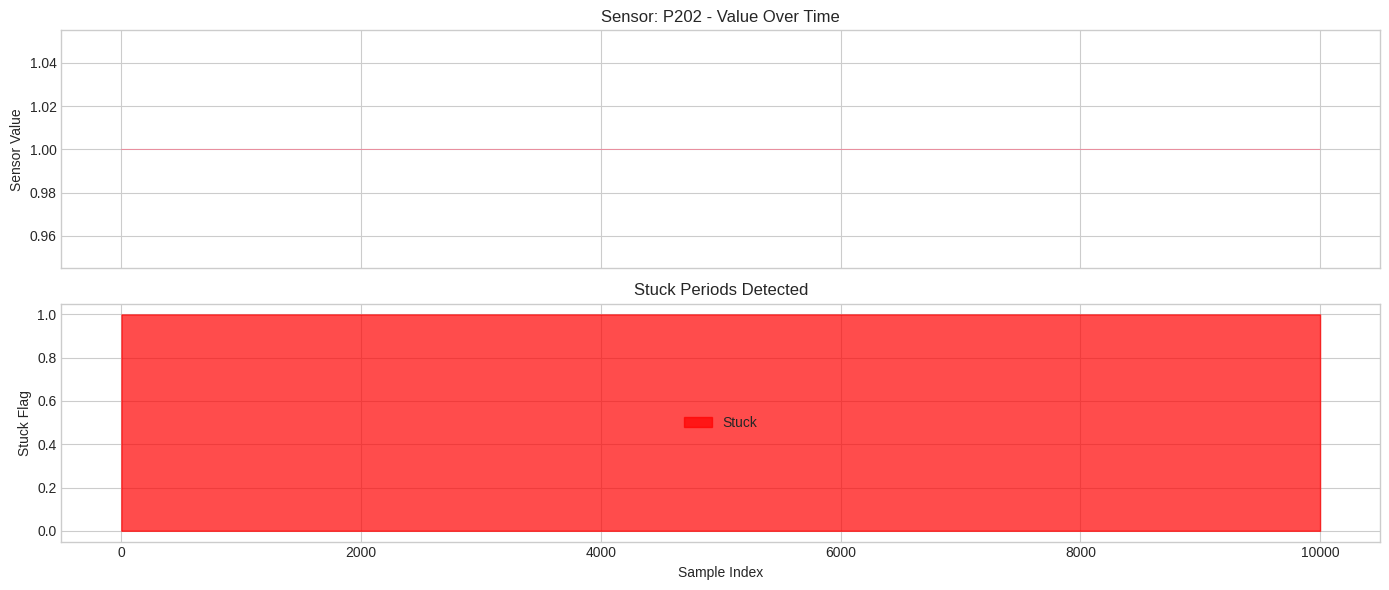

In [9]:
# Visualize stuck sensor periods
if len(stuck_sensors) > 0:
    # Pick top sensor with stuck periods
    example_sensor = stuck_sensors.index[0]

    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    # Plot sensor values
    sample_range = min(10000, len(sensors_df))
    axes[0].plot(sensors_df[example_sensor].iloc[:sample_range], linewidth=0.5)
    axes[0].set_ylabel('Sensor Value')
    axes[0].set_title(f'Sensor: {example_sensor} - Value Over Time')

    # Plot stuck flags
    axes[1].fill_between(range(sample_range), stuck_flags[example_sensor].iloc[:sample_range],
                         alpha=0.7, color='red', label='Stuck')
    axes[1].set_ylabel('Stuck Flag')
    axes[1].set_xlabel('Sample Index')
    axes[1].set_title('Stuck Periods Detected')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('anomaly_stuck_sensor.png', dpi=150)
    plt.show()
else:
    print("No stuck sensors detected in the dataset.")

---
## Anomaly Type 2: Sensor Drift Detection

**Sensor drift** is a gradual deviation from expected values over time. This can indicate:
- Sensor calibration issues
- Aging or degradation
- Environmental changes
- Slow, stealthy attacks

In [10]:
def detect_drift(df, window=300, threshold=3.0):
    """
    Detect sensor drift using rolling mean deviation from overall mean.

    Args:
        df: DataFrame with sensor columns
        window: Rolling window size
        threshold: Z-score threshold for drift detection

    Returns:
        DataFrame with drift scores and flags
    """
    drift_scores = pd.DataFrame(index=df.index)
    drift_flags = pd.DataFrame(index=df.index)

    for col in df.columns:
        # Overall statistics
        overall_mean = df[col].mean()
        overall_std = df[col].std()

        if overall_std == 0:
            drift_scores[col] = 0
            drift_flags[col] = 0
            continue

        # Rolling mean
        rolling_mean = df[col].rolling(window=window, min_periods=1).mean()

        # Z-score of rolling mean vs overall mean
        drift_scores[col] = (rolling_mean - overall_mean) / overall_std
        drift_flags[col] = (np.abs(drift_scores[col]) > threshold).astype(int)

    return drift_scores, drift_flags

print("Detecting sensor drift...")
drift_scores, drift_flags = detect_drift(
    sensors_df,
    window=CONFIG['drift_window'],
    threshold=CONFIG['drift_threshold']
)

# Summary
drift_summary = drift_flags.sum()
drifting_sensors = drift_summary[drift_summary > 0].sort_values(ascending=False)

print(f"\n✅ Drift detection complete!")
print(f"\nSensors with drift periods (top 15):")
print(drifting_sensors.head(15))

Detecting sensor drift...

✅ Drift detection complete!

Sensors with drift periods (top 15):
FIT504    32735
UV401     32494
P501      32488
LIT401    32343
FIT401    32312
P402      31828
PIT503    31827
FIT501    31826
FIT502    31826
PIT501    31826
FIT503    31825
AIT402    28545
AIT502    19517
AIT501    19335
AIT401     5417
dtype: int64


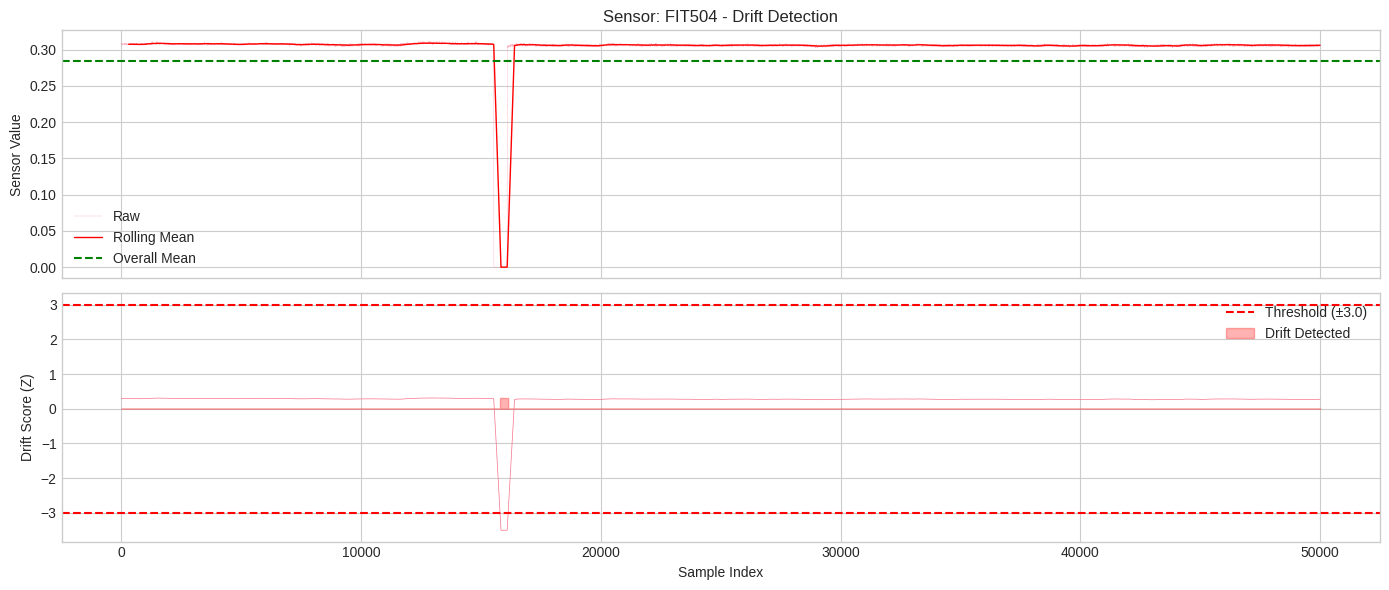

In [11]:
# Visualize drift
if len(drifting_sensors) > 0:
    example_sensor = drifting_sensors.index[0]

    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    sample_range = min(50000, len(sensors_df))

    # Plot sensor values with rolling mean
    axes[0].plot(sensors_df[example_sensor].iloc[:sample_range], linewidth=0.3, alpha=0.5, label='Raw')
    rolling_mean = sensors_df[example_sensor].rolling(window=CONFIG['drift_window']).mean()
    axes[0].plot(rolling_mean.iloc[:sample_range], linewidth=1, color='red', label='Rolling Mean')
    axes[0].axhline(y=sensors_df[example_sensor].mean(), color='green', linestyle='--', label='Overall Mean')
    axes[0].set_ylabel('Sensor Value')
    axes[0].set_title(f'Sensor: {example_sensor} - Drift Detection')
    axes[0].legend()

    # Plot drift score
    axes[1].plot(drift_scores[example_sensor].iloc[:sample_range], linewidth=0.5)
    axes[1].axhline(y=CONFIG['drift_threshold'], color='red', linestyle='--', label=f'Threshold (±{CONFIG["drift_threshold"]})')
    axes[1].axhline(y=-CONFIG['drift_threshold'], color='red', linestyle='--')
    axes[1].fill_between(range(sample_range), drift_flags[example_sensor].iloc[:sample_range] * drift_scores[example_sensor].iloc[:sample_range].max(),
                         alpha=0.3, color='red', label='Drift Detected')
    axes[1].set_ylabel('Drift Score (Z)')
    axes[1].set_xlabel('Sample Index')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('anomaly_drift.png', dpi=150)
    plt.show()
else:
    print("No significant drift detected.")

---
## Anomaly Type 3: Noise Burst Detection

**Noise bursts** are sudden increases in signal variability. This can indicate:
- Electromagnetic interference (EMI)
- Loose connections
- Sensor malfunction
- Process instability

In [12]:
def detect_noise_bursts(df, window=30, multiplier=5.0):
    """
    Detect periods of abnormally high noise (variance).

    Args:
        df: DataFrame with sensor columns
        window: Rolling window size
        multiplier: How many times normal variance = noise burst

    Returns:
        DataFrame with noise scores and flags
    """
    noise_scores = pd.DataFrame(index=df.index)
    noise_flags = pd.DataFrame(index=df.index)

    for col in df.columns:
        # Calculate rolling standard deviation
        rolling_std = df[col].rolling(window=window, min_periods=1).std()

        # Baseline noise (median of rolling std)
        baseline_noise = rolling_std.median()

        if baseline_noise == 0:
            noise_scores[col] = 0
            noise_flags[col] = 0
            continue

        # Noise ratio
        noise_scores[col] = rolling_std / baseline_noise
        noise_flags[col] = (noise_scores[col] > multiplier).astype(int)

    return noise_scores, noise_flags

print("Detecting noise bursts...")
noise_scores, noise_flags = detect_noise_bursts(
    sensors_df,
    window=CONFIG['noise_window'],
    multiplier=CONFIG['noise_multiplier']
)

# Summary
noise_summary = noise_flags.sum()
noisy_sensors = noise_summary[noise_summary > 0].sort_values(ascending=False)

print(f"\n✅ Noise burst detection complete!")
print(f"\nSensors with noise bursts (top 15):")
print(noisy_sensors.head(15))

Detecting noise bursts...

✅ Noise burst detection complete!

Sensors with noise bursts (top 15):
AIT501     158731
LIT301      69350
FIT301      32933
DPIT301     31085
AIT203      21119
AIT503      11686
FIT201      10263
AIT202       9442
FIT101       6604
AIT402       3834
LIT101       3266
AIT502       3098
AIT504        827
FIT401        485
PIT501        453
dtype: int64


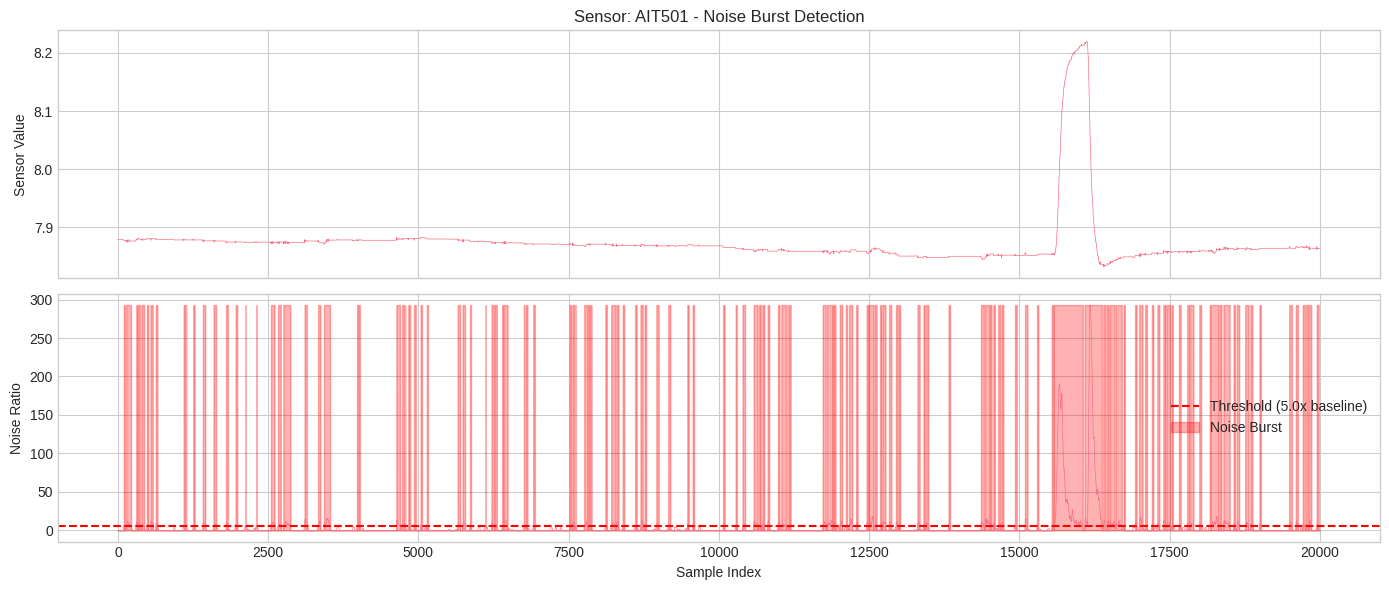

In [13]:
# Visualize noise bursts
if len(noisy_sensors) > 0:
    example_sensor = noisy_sensors.index[0]

    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    sample_range = min(20000, len(sensors_df))

    # Plot sensor values
    axes[0].plot(sensors_df[example_sensor].iloc[:sample_range], linewidth=0.5)
    axes[0].set_ylabel('Sensor Value')
    axes[0].set_title(f'Sensor: {example_sensor} - Noise Burst Detection')

    # Plot noise score
    axes[1].plot(noise_scores[example_sensor].iloc[:sample_range], linewidth=0.5)
    axes[1].axhline(y=CONFIG['noise_multiplier'], color='red', linestyle='--',
                    label=f'Threshold ({CONFIG["noise_multiplier"]}x baseline)')
    axes[1].fill_between(range(sample_range),
                         noise_flags[example_sensor].iloc[:sample_range] * noise_scores[example_sensor].iloc[:sample_range].max(),
                         alpha=0.3, color='red', label='Noise Burst')
    axes[1].set_ylabel('Noise Ratio')
    axes[1].set_xlabel('Sample Index')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('anomaly_noise.png', dpi=150)
    plt.show()
else:
    print("No significant noise bursts detected.")

---
## Anomaly Type 4: Out-of-Range Detection

**Out-of-range** values exceed the normal operating limits. This can indicate:
- Sensor malfunction
- Process upset
- Attack injecting invalid values

In [14]:
def detect_out_of_range(df, percentile=99.9):
    """
    Detect values outside normal operating range.

    Args:
        df: DataFrame with sensor columns
        percentile: Percentile for determining limits

    Returns:
        DataFrame with out-of-range flags, and limits dict
    """
    oor_flags = pd.DataFrame(index=df.index)
    limits = {}

    for col in df.columns:
        # Calculate limits based on percentiles
        lower = df[col].quantile((100 - percentile) / 100)
        upper = df[col].quantile(percentile / 100)

        limits[col] = {'lower': lower, 'upper': upper}

        # Flag out-of-range values
        oor_flags[col] = ((df[col] < lower) | (df[col] > upper)).astype(int)

    return oor_flags, limits

print("Detecting out-of-range values...")
oor_flags, sensor_limits = detect_out_of_range(
    sensors_df,
    percentile=CONFIG['oor_percentile']
)

# Summary
oor_summary = oor_flags.sum()
oor_sensors = oor_summary[oor_summary > 0].sort_values(ascending=False)

print(f"\n✅ Out-of-range detection complete!")
print(f"\nSensors with out-of-range values (top 15):")
print(oor_sensors.head(15))

Detecting out-of-range values...

✅ Out-of-range detection complete!

Sensors with out-of-range values (top 15):
AIT503    888
AIT502    864
FIT502    860
LIT401    855
AIT203    848
AIT504    847
PIT501    831
AIT202    800
AIT201    718
AIT402    709
PIT503    691
LIT101    576
AIT501    536
FIT501    511
FIT503    488
dtype: int64


In [15]:
# Show sensor limits
print("\nSensor Operating Limits (based on data):")
limits_df = pd.DataFrame(sensor_limits).T
limits_df.columns = ['Lower Limit', 'Upper Limit']
display(limits_df.head(15))


Sensor Operating Limits (based on data):


,Lower Limit,Upper Limit
FIT101,0.000000,2.688403
LIT101,244.000000,866.543900
MV101,0.000000,2.000000
P101,1.000000,2.000000
P102,1.000000,2.000000
AIT201,168.162000,263.746500
AIT202,8.348693,8.719431
AIT203,286.131800,373.878500
FIT201,0.000000,2.806010
MV201,0.000000,2.000000


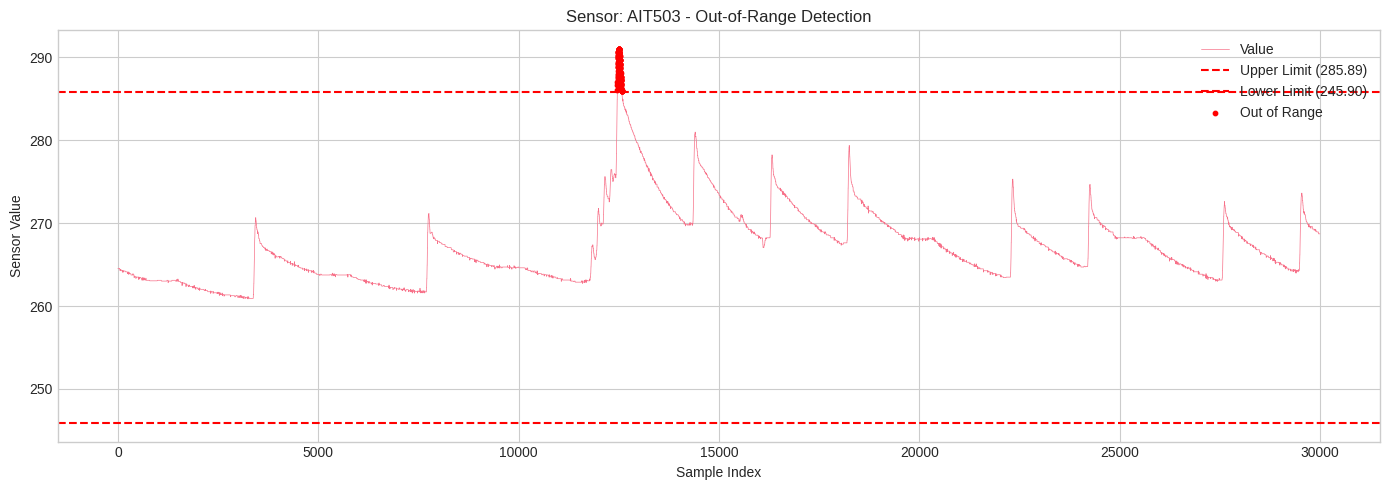

In [16]:
# Visualize out-of-range
if len(oor_sensors) > 0:
    example_sensor = oor_sensors.index[0]

    fig, ax = plt.subplots(figsize=(14, 5))

    sample_range = min(30000, len(sensors_df))

    # Plot sensor values
    ax.plot(sensors_df[example_sensor].iloc[:sample_range], linewidth=0.5, label='Value')

    # Plot limits
    ax.axhline(y=sensor_limits[example_sensor]['upper'], color='red', linestyle='--',
               label=f'Upper Limit ({sensor_limits[example_sensor]["upper"]:.2f})')
    ax.axhline(y=sensor_limits[example_sensor]['lower'], color='red', linestyle='--',
               label=f'Lower Limit ({sensor_limits[example_sensor]["lower"]:.2f})')

    # Highlight out-of-range points
    oor_indices = np.where(oor_flags[example_sensor].iloc[:sample_range] == 1)[0]
    ax.scatter(oor_indices, sensors_df[example_sensor].iloc[oor_indices],
               color='red', s=10, label='Out of Range', zorder=5)

    ax.set_ylabel('Sensor Value')
    ax.set_xlabel('Sample Index')
    ax.set_title(f'Sensor: {example_sensor} - Out-of-Range Detection')
    ax.legend()

    plt.tight_layout()
    plt.savefig('anomaly_out_of_range.png', dpi=150)
    plt.show()
else:
    print("No out-of-range values detected.")

---
## Anomaly Type 5: Spike Detection

**Spikes** are sudden, sharp changes in sensor values. This can indicate:
- Process disturbances
- Valve operations
- Attack injecting abnormal values

In [17]:
def detect_spikes(df, threshold=5.0):
    """
    Detect sudden spikes using rate of change.

    Args:
        df: DataFrame with sensor columns
        threshold: Z-score threshold for spike detection

    Returns:
        DataFrame with spike flags
    """
    spike_flags = pd.DataFrame(index=df.index)
    spike_scores = pd.DataFrame(index=df.index)

    for col in df.columns:
        # Calculate rate of change (first difference)
        diff = df[col].diff().abs()

        # Z-score of rate of change
        diff_mean = diff.mean()
        diff_std = diff.std()

        if diff_std == 0:
            spike_scores[col] = 0
            spike_flags[col] = 0
            continue

        spike_scores[col] = (diff - diff_mean) / diff_std
        spike_flags[col] = (spike_scores[col] > threshold).astype(int)

    return spike_scores, spike_flags

print("Detecting spikes...")
spike_scores, spike_flags = detect_spikes(
    sensors_df,
    threshold=CONFIG['spike_threshold']
)

# Summary
spike_summary = spike_flags.sum()
spiking_sensors = spike_summary[spike_summary > 0].sort_values(ascending=False)

print(f"\n✅ Spike detection complete!")
print(f"\nSensors with spikes (top 15):")
print(spiking_sensors.head(15))

Detecting spikes...

✅ Spike detection complete!

Sensors with spikes (top 15):
AIT501     5916
PIT502     5517
AIT503     3245
AIT203     3166
FIT301     2986
DPIT301    2538
FIT601     2168
FIT201     2006
FIT101     1813
AIT401     1243
MV302       868
MV304       868
AIT201      591
MV303       538
MV301       536
dtype: int64


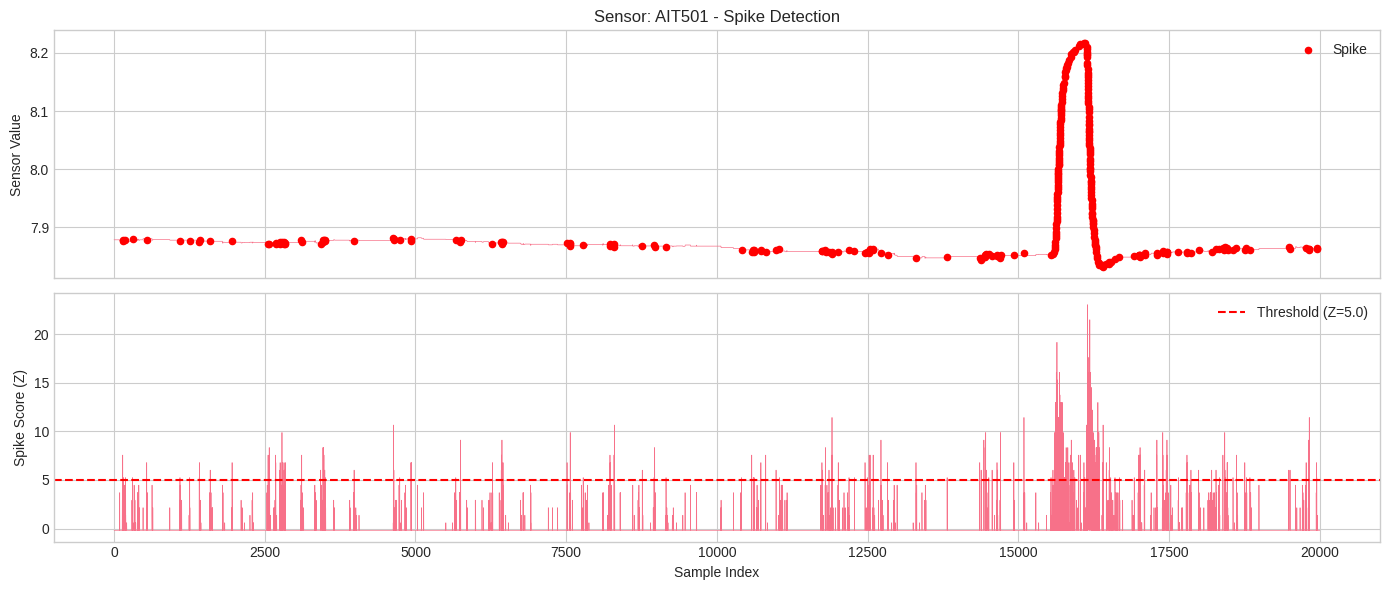

In [18]:
# Visualize spikes
if len(spiking_sensors) > 0:
    example_sensor = spiking_sensors.index[0]

    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    sample_range = min(20000, len(sensors_df))

    # Plot sensor values
    axes[0].plot(sensors_df[example_sensor].iloc[:sample_range], linewidth=0.5)

    # Mark spike locations
    spike_indices = np.where(spike_flags[example_sensor].iloc[:sample_range] == 1)[0]
    axes[0].scatter(spike_indices, sensors_df[example_sensor].iloc[spike_indices],
                    color='red', s=20, label='Spike', zorder=5)
    axes[0].set_ylabel('Sensor Value')
    axes[0].set_title(f'Sensor: {example_sensor} - Spike Detection')
    axes[0].legend()

    # Plot spike scores
    axes[1].plot(spike_scores[example_sensor].iloc[:sample_range], linewidth=0.5)
    axes[1].axhline(y=CONFIG['spike_threshold'], color='red', linestyle='--',
                    label=f'Threshold (Z={CONFIG["spike_threshold"]})')
    axes[1].set_ylabel('Spike Score (Z)')
    axes[1].set_xlabel('Sample Index')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('anomaly_spikes.png', dpi=150)
    plt.show()
else:
    print("No significant spikes detected.")

---
## Anomaly Type 6: Data Drop / Missing Values

**Data drops** occur when sensor readings are missing. This can indicate:
- Network communication issues
- Sensor failure
- Data logging problems

In [19]:
def detect_data_drops(df):
    """
    Detect missing values in sensor data.

    Returns:
        DataFrame with missing value flags, and summary
    """
    missing_flags = df.isna().astype(int)

    # Summary
    missing_counts = missing_flags.sum()
    missing_pct = (missing_counts / len(df)) * 100

    summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing %': missing_pct
    })

    return missing_flags, summary

print("Detecting data drops (missing values)...")
missing_flags, missing_summary = detect_data_drops(sensors_df)

# Filter to sensors with missing data
sensors_with_missing = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print(f"\n✅ Data drop detection complete!")
if len(sensors_with_missing) > 0:
    print(f"\nSensors with missing data:")
    print(sensors_with_missing)
else:
    print("\nNo missing data found in any sensor!")

Detecting data drops (missing values)...

✅ Data drop detection complete!

No missing data found in any sensor!


---
## Anomaly Type 7: Correlation Break Detection

**Correlation breaks** occur when sensors that should be correlated stop being correlated. This can indicate:
- Sensor malfunction
- Process change
- Attack manipulating specific sensors

In [20]:
# Find highly correlated sensor pairs
print("Calculating sensor correlations...")
correlation_matrix = sensors_df.corr()

# Find pairs with high correlation (excluding self-correlation)
high_corr_pairs = []
for i, col1 in enumerate(correlation_matrix.columns):
    for j, col2 in enumerate(correlation_matrix.columns):
        if i < j:  # Avoid duplicates
            corr = correlation_matrix.loc[col1, col2]
            if abs(corr) > 0.8:  # High correlation threshold
                high_corr_pairs.append((col1, col2, corr))

high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"\nFound {len(high_corr_pairs)} highly correlated sensor pairs:")
for pair in high_corr_pairs[:10]:
    print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.4f}")

Calculating sensor correlations...

Found 102 highly correlated sensor pairs:
  UV401 <-> P501: 0.9999
  PIT501 <-> PIT503: 0.9999
  P203 <-> P205: 0.9990
  FIT501 <-> PIT501: 0.9989
  FIT501 <-> PIT503: 0.9988
  FIT503 <-> PIT501: 0.9986
  FIT501 <-> FIT502: 0.9986
  FIT503 <-> PIT503: 0.9977
  FIT501 <-> FIT503: 0.9977
  P402 <-> FIT501: 0.9971


In [21]:
def detect_correlation_breaks(df, sensor1, sensor2, window=300, threshold=0.3):
    """
    Detect periods where correlation between two sensors breaks down.

    Args:
        df: DataFrame with sensor columns
        sensor1, sensor2: Column names of sensor pair
        window: Rolling window for correlation
        threshold: Minimum expected correlation

    Returns:
        Rolling correlation series, break flags
    """
    # Calculate rolling correlation
    rolling_corr = df[sensor1].rolling(window=window).corr(df[sensor2])

    # Overall correlation
    overall_corr = df[sensor1].corr(df[sensor2])

    # Detect breaks (correlation drops significantly)
    if overall_corr > 0:
        break_flags = (rolling_corr < threshold).astype(int)
    else:
        break_flags = (rolling_corr > -threshold).astype(int)

    return rolling_corr, break_flags, overall_corr

# Analyze correlation breaks for top correlated pair
if len(high_corr_pairs) > 0:
    s1, s2, overall = high_corr_pairs[0]

    print(f"\nAnalyzing correlation breaks between {s1} and {s2}...")
    print(f"Overall correlation: {overall:.4f}")

    rolling_corr, corr_breaks, _ = detect_correlation_breaks(
        sensors_df, s1, s2,
        window=CONFIG['corr_window'],
        threshold=CONFIG['corr_threshold']
    )

    print(f"Correlation break periods: {corr_breaks.sum():,} samples")


Analyzing correlation breaks between UV401 and P501...
Overall correlation: 0.9999
Correlation break periods: 0 samples


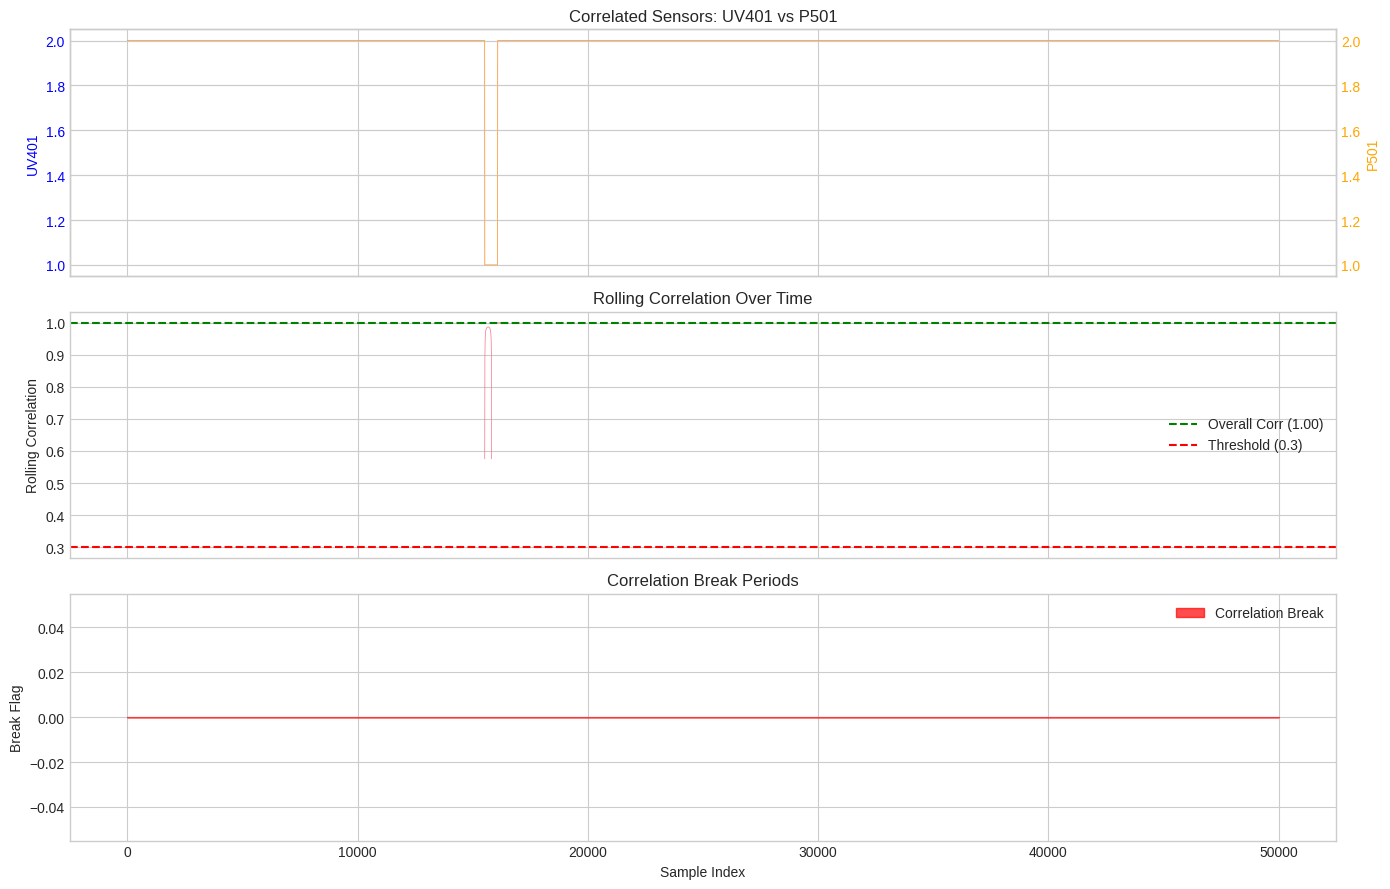

In [22]:
# Visualize correlation breaks
if len(high_corr_pairs) > 0:
    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

    sample_range = min(50000, len(sensors_df))

    # Plot both sensors
    ax1 = axes[0]
    ax1.plot(sensors_df[s1].iloc[:sample_range], linewidth=0.5, label=s1, alpha=0.7)
    ax1.set_ylabel(s1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax1b = ax1.twinx()
    ax1b.plot(sensors_df[s2].iloc[:sample_range], linewidth=0.5, color='orange', label=s2, alpha=0.7)
    ax1b.set_ylabel(s2, color='orange')
    ax1b.tick_params(axis='y', labelcolor='orange')
    ax1.set_title(f'Correlated Sensors: {s1} vs {s2}')

    # Plot rolling correlation
    axes[1].plot(rolling_corr.iloc[:sample_range], linewidth=0.5)
    axes[1].axhline(y=overall, color='green', linestyle='--', label=f'Overall Corr ({overall:.2f})')
    axes[1].axhline(y=CONFIG['corr_threshold'], color='red', linestyle='--', label=f'Threshold ({CONFIG["corr_threshold"]})')
    axes[1].set_ylabel('Rolling Correlation')
    axes[1].legend()
    axes[1].set_title('Rolling Correlation Over Time')

    # Plot correlation breaks
    axes[2].fill_between(range(sample_range), corr_breaks.iloc[:sample_range],
                         alpha=0.7, color='red', label='Correlation Break')
    axes[2].set_ylabel('Break Flag')
    axes[2].set_xlabel('Sample Index')
    axes[2].legend()
    axes[2].set_title('Correlation Break Periods')

    plt.tight_layout()
    plt.savefig('anomaly_correlation_break.png', dpi=150)
    plt.show()

---
## Step 4: Combined Anomaly Summary

In [23]:
# Combine all anomaly types
print("="*80)
print("COMBINED ANOMALY SUMMARY")
print("="*80)

# Create summary DataFrame
anomaly_summary = pd.DataFrame(index=sensor_cols)
anomaly_summary['Stuck Periods'] = stuck_flags.sum()
anomaly_summary['Drift Periods'] = drift_flags.sum()
anomaly_summary['Noise Bursts'] = noise_flags.sum()
anomaly_summary['Out-of-Range'] = oor_flags.sum()
anomaly_summary['Spikes'] = spike_flags.sum()
anomaly_summary['Total Anomalies'] = anomaly_summary.sum(axis=1)

# Sort by total anomalies
anomaly_summary = anomaly_summary.sort_values('Total Anomalies', ascending=False)

print("\nTop 20 Sensors by Total Anomalies:")
display(anomaly_summary.head(20))

COMBINED ANOMALY SUMMARY

Top 20 Sensors by Total Anomalies:


,Stuck Periods,Drift Periods,Noise Bursts,Out-of-Range,Spikes,Total Anomalies
AIT501,448583,19335,158731,536,5916,633101
FIT504,449295,32735,359,320,94,482803
FIT401,449023,32312,485,364,85,482269
FIT501,449201,31826,407,511,120,482065
FIT503,449209,31825,408,488,118,482048
UV401,449385,32494,0,0,10,481889
P501,449384,32488,0,0,10,481882
P402,449545,31828,0,0,14,481387
AIT401,446169,5417,0,427,1243,453256
P102,449446,3713,0,0,8,453167


In [24]:
# Anomaly type distribution
anomaly_totals = {
    'Stuck Sensor': stuck_flags.sum().sum(),
    'Drift': drift_flags.sum().sum(),
    'Noise Burst': noise_flags.sum().sum(),
    'Out-of-Range': oor_flags.sum().sum(),
    'Spike': spike_flags.sum().sum()
}

print("\nTotal Anomalies by Type:")
for atype, count in sorted(anomaly_totals.items(), key=lambda x: x[1], reverse=True):
    print(f"  {atype}: {count:,}")


Total Anomalies by Type:
  Stuck Sensor: 16,696,146
  Drift: 438,565
  Noise Burst: 365,612
  Spike: 37,766
  Out-of-Range: 14,744


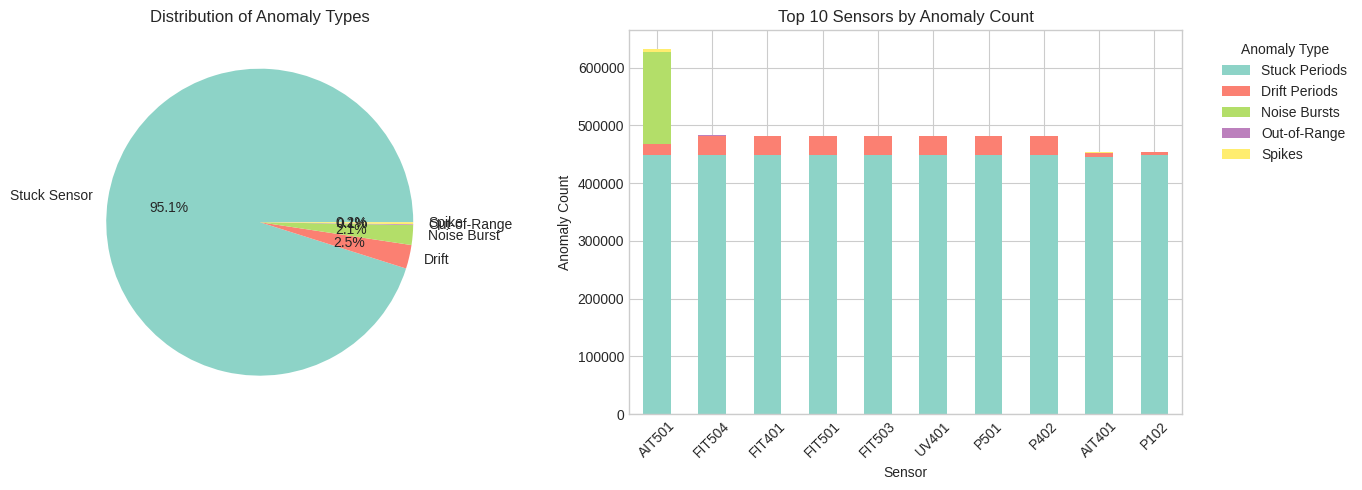

In [25]:
# Visualize anomaly distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of anomaly types
ax1 = axes[0]
colors = plt.cm.Set3(np.linspace(0, 1, len(anomaly_totals)))
wedges, texts, autotexts = ax1.pie(
    anomaly_totals.values(),
    labels=anomaly_totals.keys(),
    autopct='%1.1f%%',
    colors=colors
)
ax1.set_title('Distribution of Anomaly Types')

# Bar chart of top sensors
ax2 = axes[1]
top_sensors = anomaly_summary.head(10)
top_sensors[['Stuck Periods', 'Drift Periods', 'Noise Bursts', 'Out-of-Range', 'Spikes']].plot(
    kind='bar', stacked=True, ax=ax2, colormap='Set3'
)
ax2.set_xlabel('Sensor')
ax2.set_ylabel('Anomaly Count')
ax2.set_title('Top 10 Sensors by Anomaly Count')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Anomaly Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('anomaly_summary.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Step 5: Correlation with Attack Labels

In [26]:
if label_col:
    print("Analyzing correlation between anomalies and attacks...")

    # Create combined anomaly flag (any anomaly detected)
    any_anomaly = (
        (stuck_flags.sum(axis=1) > 0) |
        (drift_flags.sum(axis=1) > 0) |
        (noise_flags.sum(axis=1) > 0) |
        (oor_flags.sum(axis=1) > 0) |
        (spike_flags.sum(axis=1) > 0)
    ).astype(int)

    # Attack flag
    attack_flag = (data[label_col] == 'Attack').astype(int)

    # Create confusion-like matrix
    both = ((any_anomaly == 1) & (attack_flag == 1)).sum()
    anomaly_only = ((any_anomaly == 1) & (attack_flag == 0)).sum()
    attack_only = ((any_anomaly == 0) & (attack_flag == 1)).sum()
    neither = ((any_anomaly == 0) & (attack_flag == 0)).sum()

    print(f"\nAnomaly vs Attack Analysis:")
    print(f"  Both anomaly and attack:    {both:,}")
    print(f"  Anomaly but not attack:     {anomaly_only:,} (potential false positives or equipment issues)")
    print(f"  Attack but no anomaly:      {attack_only:,} (missed attacks)")
    print(f"  Neither:                    {neither:,}")

    # Detection rate
    total_attacks = attack_flag.sum()
    if total_attacks > 0:
        detection_rate = both / total_attacks * 100
        print(f"\nAttack Detection Rate (via anomaly detection): {detection_rate:.2f}%")
else:
    print("No label column available for attack correlation analysis.")

Analyzing correlation between anomalies and attacks...

Anomaly vs Attack Analysis:
  Both anomaly and attack:    54,621
  Anomaly but not attack:     395,297 (potential false positives or equipment issues)
  Attack but no anomaly:      0 (missed attacks)
  Neither:                    1

Attack Detection Rate (via anomaly detection): 100.00%


In [27]:
# Per-anomaly-type detection of attacks
if label_col:
    print("\nAttack Detection by Anomaly Type:")
    print("-" * 50)

    attack_flag = (data[label_col] == 'Attack').astype(int)
    total_attacks = attack_flag.sum()

    anomaly_types = {
        'Stuck Sensor': stuck_flags.sum(axis=1) > 0,
        'Drift': drift_flags.sum(axis=1) > 0,
        'Noise Burst': noise_flags.sum(axis=1) > 0,
        'Out-of-Range': oor_flags.sum(axis=1) > 0,
        'Spike': spike_flags.sum(axis=1) > 0
    }

    detection_stats = []
    for atype, flags in anomaly_types.items():
        detected = ((flags) & (attack_flag == 1)).sum()
        false_pos = ((flags) & (attack_flag == 0)).sum()
        detection_rate = detected / total_attacks * 100 if total_attacks > 0 else 0

        detection_stats.append({
            'Anomaly Type': atype,
            'Attacks Detected': detected,
            'Detection Rate %': detection_rate,
            'False Positives': false_pos
        })

    detection_df = pd.DataFrame(detection_stats)
    display(detection_df)


Attack Detection by Anomaly Type:
--------------------------------------------------


,Anomaly Type,Attacks Detected,Detection Rate %,False Positives
0,Stuck Sensor,54621,100.000000,395297
1,Drift,39637,72.567328,10474
2,Noise Burst,27538,50.416506,208944
3,Out-of-Range,4972,9.102726,8352
4,Spike,2775,5.080464,28179


---
## Step 6: Save Results

In [28]:
# Save anomaly summary
anomaly_summary.to_csv('anomaly_type_summary.csv')
print("Saved: anomaly_type_summary.csv")

# Save sensor limits
pd.DataFrame(sensor_limits).T.to_csv('sensor_limits.csv')
print("Saved: sensor_limits.csv")

# Save high correlation pairs
corr_df = pd.DataFrame(high_corr_pairs, columns=['Sensor1', 'Sensor2', 'Correlation'])
corr_df.to_csv('sensor_correlations.csv', index=False)
print("Saved: sensor_correlations.csv")

print("\n✅ All results saved!")

Saved: anomaly_type_summary.csv
Saved: sensor_limits.csv
Saved: sensor_correlations.csv

✅ All results saved!


---
## Summary and Recommendations

In [29]:
print("="*80)
print("MULTI-TYPE ANOMALY DETECTION SUMMARY")
print("="*80)

print(f"""
📊 ANOMALY TYPES DETECTED:

1. STUCK SENSORS
   - Sensors affected: {len(stuck_sensors)}
   - Total stuck periods: {stuck_flags.sum().sum():,}
   - Most affected: {stuck_sensors.index[0] if len(stuck_sensors) > 0 else 'None'}

2. SENSOR DRIFT
   - Sensors affected: {len(drifting_sensors)}
   - Total drift periods: {drift_flags.sum().sum():,}
   - Most affected: {drifting_sensors.index[0] if len(drifting_sensors) > 0 else 'None'}

3. NOISE BURSTS
   - Sensors affected: {len(noisy_sensors)}
   - Total noise periods: {noise_flags.sum().sum():,}
   - Most affected: {noisy_sensors.index[0] if len(noisy_sensors) > 0 else 'None'}

4. OUT-OF-RANGE VALUES
   - Sensors affected: {len(oor_sensors)}
   - Total OOR values: {oor_flags.sum().sum():,}
   - Most affected: {oor_sensors.index[0] if len(oor_sensors) > 0 else 'None'}

5. SPIKES
   - Sensors affected: {len(spiking_sensors)}
   - Total spikes: {spike_flags.sum().sum():,}
   - Most affected: {spiking_sensors.index[0] if len(spiking_sensors) > 0 else 'None'}

6. CORRELATION BREAKS
   - High correlation pairs found: {len(high_corr_pairs)}
""")

print("""
📋 RECOMMENDATIONS FOR SCADA OPERATORS:

1. STUCK SENSORS → Check sensor connections, recalibrate, verify communication
2. DRIFT → Schedule calibration, check for environmental factors
3. NOISE BURSTS → Investigate EMI sources, check shielding, inspect wiring
4. OUT-OF-RANGE → Verify physical process limits, check for attacks
5. SPIKES → Correlate with process events, investigate if unexpected
6. CORRELATION BREAKS → Check both sensors, may indicate attack or failure

💡 KEY INSIGHT:
Not all anomalies are attacks! Multi-type detection helps distinguish between:
- Equipment failures (stuck, drift, noise)
- Process upsets (spikes, OOR)
- Potential attacks (correlation breaks, unexpected patterns)
""")

print("="*80)

MULTI-TYPE ANOMALY DETECTION SUMMARY

📊 ANOMALY TYPES DETECTED:

1. STUCK SENSORS
   - Sensors affected: 51
   - Total stuck periods: 16,696,146
   - Most affected: P202

2. SENSOR DRIFT
   - Sensors affected: 27
   - Total drift periods: 438,565
   - Most affected: FIT504

3. NOISE BURSTS
   - Sensors affected: 22
   - Total noise periods: 365,612
   - Most affected: AIT501

4. OUT-OF-RANGE VALUES
   - Sensors affected: 28
   - Total OOR values: 14,744
   - Most affected: AIT503

5. SPIKES
   - Sensors affected: 44
   - Total spikes: 37,766
   - Most affected: AIT501

6. CORRELATION BREAKS
   - High correlation pairs found: 102


📋 RECOMMENDATIONS FOR SCADA OPERATORS:

1. STUCK SENSORS → Check sensor connections, recalibrate, verify communication
2. DRIFT → Schedule calibration, check for environmental factors
3. NOISE BURSTS → Investigate EMI sources, check shielding, inspect wiring
4. OUT-OF-RANGE → Verify physical process limits, check for attacks
5. SPIKES → Correlate with process